gold                                         A         B         C         D
model                                                                       
Qwen/Qwen2.5-7B-Instruct              0.646199  0.678363  0.672515  0.707602
meta-llama/Llama-3.1-8B-Instruct      0.513158  0.545322  0.526316  0.624269
mistralai/Ministral-8B-Instruct-2410  0.599415  0.673977  0.673977  0.616959


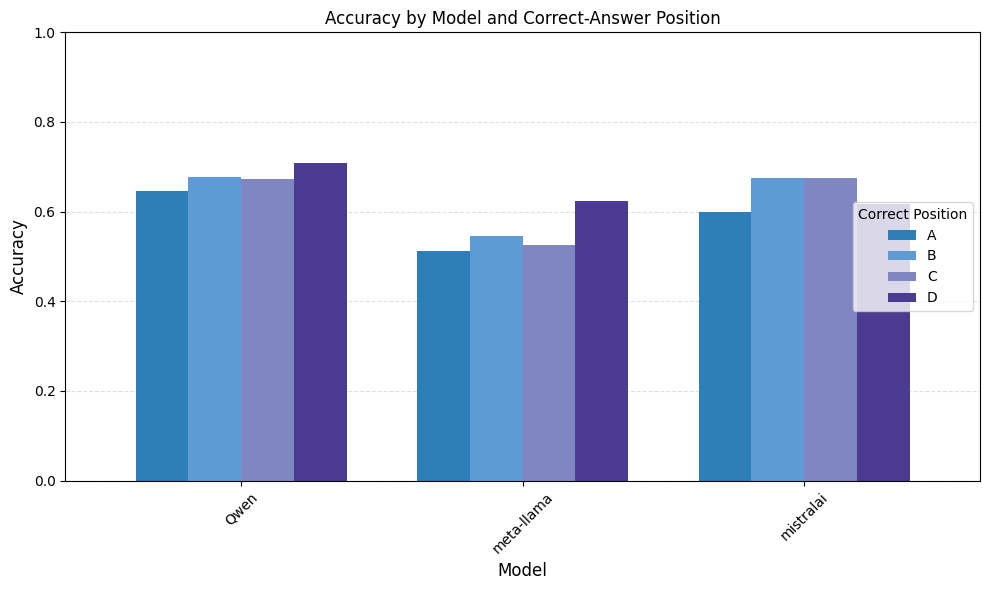

gold            A      B      C      D
model                                 
Qwen        0.646  0.678  0.673  0.708
meta-llama  0.513  0.545  0.526  0.624
mistralai   0.599  0.674  0.674  0.617


In [2]:
# visualize results of mc evalution depending on golden answer position
import pandas as pd
import matplotlib.pyplot as plt



file_path = "pos_bias.csv"


colors = ["#2C7FB8",  
    "#5E9BD4",  
    "#7F86C2",
    "#4B3C91"]

def trim(name):
    return name.split('/')[0] 


df_prompts = pd.read_csv(file_path)

acc_by_model_position = (
    df_prompts
      .groupby(["model", "gold"])["correct"]
      .mean()
      .unstack()
      .sort_index(axis=1)       
)

print(acc_by_model_position)
acc_by_model_position.index = acc_by_model_position.index.map(trim)


ax = acc_by_model_position[["A","B","C","D"]].plot(
    kind="bar",
    figsize=(10, 6),
    ylim=(0, 1),
    color=colors,
    linewidth=0.6,
    width=0.75,
)

ax.set_ylabel("Accuracy", fontsize=12)
ax.set_xlabel("Model",   fontsize=12)
ax.set_title("Accuracy by Model and Correct-Answer Position")
ax.tick_params(axis="x", rotation=45)
ax.set_axisbelow(True)
ax.grid(True, axis="y", linestyle="--", alpha=0.4)


ax.legend(
    title="Correct Position",
    loc="center right",
    frameon=True
)

plt.tight_layout()
plt.show()

print(acc_by_model_position.round(3))




In [ ]:
df_prompts.iloc[]

qid                               1
model      Qwen/Qwen2.5-7B-Instruct
gold                              B
pred                              B
A                        -15.515625
B                         -0.000001
C                        -19.921875
D                        -14.453125
correct                        True
Name: 5, dtype: object

In [5]:
MODELS = [
    "Qwen/Qwen2.5-7B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
    "mistralai/Ministral-8B-Instruct-2410",
]

In [6]:


QIDS      = [0,1,2,3,4,5,6,7,34,35,36,37,38]           
OUT_HTML  = "../../visu/big_heatmap.html"
CELL_WPX  = 100                          
LEGEND_W  = 500                          


import pandas as pd, numpy as np, matplotlib, pathlib, textwrap

OPTIONS = list("ABCD")                   
cmap     = matplotlib.cm.get_cmap("RdYlGn")


df = df_prompts.copy()
df = df[df["model"].isin(MODELS) & df["qid"].isin(QIDS)]

# adjust probabilities to add up to 1
def p_correct(row):
    lp = row[OPTIONS].astype(float).to_numpy()
    p  = np.exp(lp) / np.exp(lp).sum()
    return p[OPTIONS.index(row["gold"])]

table_data = {qid: {} for qid in QIDS}
for _, row in df.iterrows():
    key = (row["model"], row["gold"])
    table_data[row["qid"]][key] = p_correct(row)

def colour(v):
    r, g, b, _ = cmap(v)
    return f"rgb({int(r*255)},{int(g*255)},{int(b*255)})"

def td(val):
    return (f'<td style="width:{CELL_WPX}px;padding:6px;text-align:center;'
            f'font-family:Arial;background:{colour(val)};">{val:.3f}</td>')

head_model = '<tr><th></th>' + ''.join(
    f'<th colspan="4" style="font-family:Arial;background:#f0f0f0;">{name}</th>'
    for name in MODELS
) + '</tr>'

head_letters = '<tr><th></th>' + ''.join(
    f'<th style="background:#f0f0f0;font-family:Arial;">{letter}</th>'
    for _ in MODELS for letter in OPTIONS
) + '</tr>'

data_rows = []
for qid in QIDS:
    cells = []
    for model_index, model in enumerate(MODELS):
        for letter_index, letter in enumerate(OPTIONS):
            val = table_data[qid].get((model, letter), np.nan)
            style_extra = ''
            # Add right border after last letter in each model section
            if letter_index == len(OPTIONS) - 1 and model_index < len(MODELS) - 1:
                style_extra = 'border-right: 6px solid white;'  # gap between model sections
            if np.isnan(val):
                cells.append(
                    f'<td style="width:{CELL_WPX}px;background:#e0e0e0;{style_extra}"></td>'
                )
            else:
                cells.append(
                    td(val).replace(';">', f';{style_extra}">')  # inject style into td
                )
    data_rows.append(
        '<tr><th style="padding:6px;background:#f0f0f0;font-family:Arial;">{}</th>{}</tr>'
        .format(qid, ''.join(cells))
    )

legend_html = f"""
<div style="margin-bottom:10px;padding:10px;background:#fafafa;
            border:1px solid #ccc;border-radius:8px;
            box-shadow:0 2px 4px rgba(0,0,0,0.1);width:{LEGEND_W}px;">
    <div style="font-family:Arial;font-size:0.9em;text-align:center;
                margin-bottom:6px;color:#333;">
        Probability of choosing the correct answer position
    </div>
    <div style="width:100%;height:18px;
                background:linear-gradient(to right,
                rgb(165,0,38), rgb(252,141,89), rgb(255,255,191),
                rgb(145,207,96), rgb(26,152,80));
                border-radius:4px;">
    </div>
    <div style="display:flex;justify-content:space-between;
                font-family:Arial;font-size:0.8em;color:#555;
                margin-top:4px;">
        <span>0</span>
        <span>1</span>
    </div>
</div>
"""

# combine
html = f"""<!DOCTYPE html>
<html><head><meta charset="utf-8">
<title>Positional bias heat‑map</title></head><body>
<div style="width:1200px; display:flex; align-items:center; flex-direction:column">
    {legend_html}
    <table style="border-collapse:collapse;border:1px solid #ccc;width:100%;">
    {head_model}
    {head_letters}
    {''.join(data_rows)}
    </table>
</div>
</body></html>
"""

pathlib.Path(OUT_HTML).write_text(html, encoding="utf-8")
print(f"√  Wrote {OUT_HTML}  with {len(QIDS)} rows × {len(MODELS)*4} data columns.")


√  Wrote ../../visu/big_heatmap.html  with 13 rows × 12 data columns.


/tmp/ipykernel_401270/257446327.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap     = matplotlib.cm.get_cmap("RdYlGn")
